In [1]:
from IPython.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

import warnings
warnings.filterwarnings("ignore")

%matplotlib notebook
from functools import partial as _partial

import numpy as np
import scipy.optimize as scyopt
import scipy.stats as scystat
from sklearn.datasets import make_regression as _create_data
# import gpy
import matplotlib.pyplot as mplt
import matplotlib.widgets as mplwid

import gp_lib as lib

mplt.rcParams.update({
    'font.size':10, 'axes.grid': True, 'grid.alpha': 0.5,
    'grid.linestyle': '--', 'grid.linewidth': 1, 'lines.linewidth': 2})

# Multivariate Gaussian

$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{{#1}}}}}$
The multivariate gaussian is the extension of the gaussian distribution to higher dimensions. It can be used to model the joint probability distribution of $N$ random variables $y_i$, which may be thought of as a vector in $\vect{y}\in \mathbb{R}^N$, : 

$$\vect{y} \sim \mathcal{N}(\vect{\mu}, \vect{\Sigma}) = \frac{1}{\sqrt{(2\pi)^N|\vect{\Sigma}|}}\exp\left(-\frac12(\vect{y}-\vect{\mu})^T\vect{\Sigma}^{-1}(\vect{y}-\vect{\mu})\right)$$

This distribution is completely characterized by the vector mean $\vect{\mu}\in\mathbb{R}^N$ and the covariance matrix $\vect{\Sigma}\in\mathbb{R}^N\times\mathbb{R}^N$.

<IPython.core.display.Javascript object>


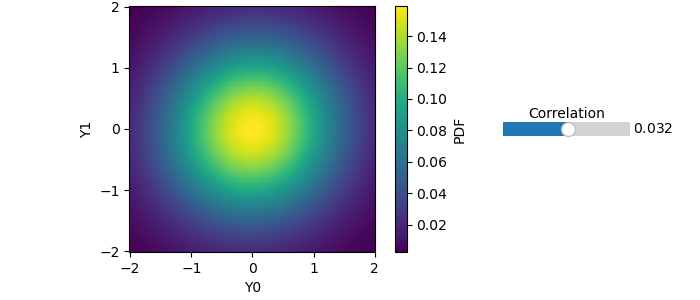

In [6]:
fig = mplt.figure(figsize=(7, 3))
gd = mplt.GridSpec(
    3, 2, right=0.9, hspace=0.3, bottom=0.16, top=0.98, left=0.1,
    height_ratios=[3, 1, 3], width_ratios=[3, 1])
ax = fig.add_subplot(gd[:, 0])

axcorr = fig.add_subplot(gd[1, 1])
scorr = mplwid.Slider(axcorr, 'Correlation', -0.999, 0.999, valinit=0)
scorr.label.set_position((0.5, 1))
scorr.label.set_horizontalalignment('center')

ax.set_ylabel('Y1')
ax.set_xlabel('Y0')
ax.grid(False)
ax.set_aspect('equal')

# Define the grid of x and y values
y1 = np.linspace(-2, 2, 200)
y1, y2 = np.meshgrid(y1, y1)
pos = np.empty(y1.shape + (2,))
pos[:, :, 0] = y1
pos[:, :, 1] = y2

mean = np.array([0.0, 0.0])
pos -= mean

surf = ax.pcolormesh(y1, y2, y2)
fig.colorbar(surf, label='PDF')

def plot_gauss(val):
    # Code done by chatgpt with a few modifications

    # Define the covariance of the distribution
    cov = np.eye(2)
    cov[0, 1] = scorr.val
    cov[1, 0] = scorr.val

    # Calculate the inverse of the covariance matrix
    covi = np.linalg.inv(cov)

    # Calculate the multivariate Gaussian distribution
    
    z = np.exp(-1/2 * np.sum(pos @ covi * pos, axis=-1))
    z *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov))

    surf.set_array(z)
    surf.set_clim([z.min(), z.max()])
    fig.canvas.draw_idle()

scorr.on_changed(plot_gauss)
plot_gauss(0)
fig.show()

In [7]:
mplt.close(fig)

## Gaussian distributions are closed under important operations:

### Marginalization:

Marginalization is the process of integrating out some variables of the gaussian distribution and only looking at some of them. 

Consider the join distribution of variables $\vect{x}$ and $\vect{y}$:

$$\begin{pmatrix}\vect{x} \\ \vect{y}\end{pmatrix} \sim
\mathcal{N}\left(
    \begin{pmatrix}\vect{\mu_x} \\ \vect{\mu_y}\end{pmatrix},
    \begin{pmatrix}\vect{\Sigma_{xx}} & \vect{\Sigma_{xy}}\\ \vect{\Sigma_{xy}}^T & \vect{\Sigma_{yy}}\end{pmatrix}\right) $$

If we are interested only on variable $\vect{x}$ we can integrate out variable $\vect{y}$:

$$\vect{x} \sim \int\,\mathrm{d}\vect{y}P(\vect{x},\vect{y}) = \mathcal{N}\left(\vect{\mu_x}, \vect{\Sigma_{xx}}\right)$$

where we notice that not only the result is gaussian, but that all the correlation terms between $\vect{x}$ and $\vect{y}$ does not appear on the final result. This means that we could have indefinetly many gaussian-distributed correlated variables, but if we are only interested in a few of them, we don't need to care to all the other correlation terms.

We can see this more clearly in the following 2D example, where we notice that varying the correlation does not change the dixtribution of $x$ on the right:

<IPython.core.display.Javascript object>


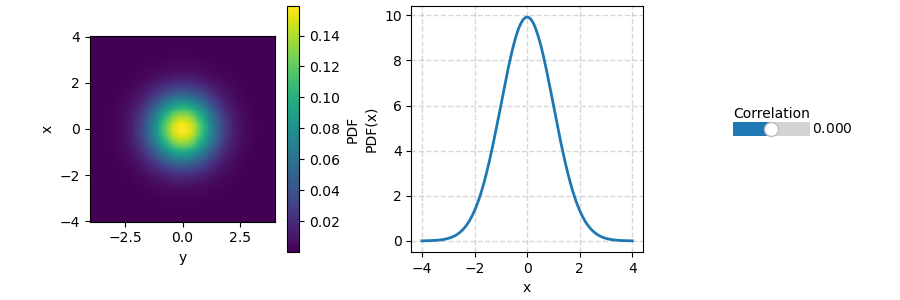

In [9]:
fig = mplt.figure(figsize=(9, 3))
gd = mplt.GridSpec(
    3, 3, right=0.9, bottom=0.16, top=0.98, left=0.1, hspace=0.3, wspace=0.5,
    height_ratios=[3, 1, 3], width_ratios=[3, 3, 1])
ax = fig.add_subplot(gd[:, 0])
ay = fig.add_subplot(gd[:, 1])

axcorr = fig.add_subplot(gd[1, 2])
scorr = mplwid.Slider(axcorr, 'Correlation', -0.999, 0.999, valinit=0)
scorr.label.set_position((0.5, 1))
scorr.label.set_horizontalalignment('center')

ax.set_ylabel('x')
ax.set_xlabel('y')
ax.grid(False)
ax.set_aspect('equal')
ay.set_xlabel('x')
ay.set_ylabel('PDF(x)')

# Define the grid of x and y values
y = np.linspace(-4, 4, 200)
y1, y2 = np.meshgrid(y, y)
pos = np.empty(y1.shape + (2,))
pos[:, :, 0] = y1
pos[:, :, 1] = y2

mean = np.array([0.0, 0.0])
pos -= mean

surf = ax.pcolormesh(y1, y2, y2)
lin, = ay.plot(y, y)
fig.colorbar(surf, label='PDF')

def plot_gauss(correlation=0):
    # Code done by chatgpt with a few modifications

    # Define the covariance of the distribution
    cov = np.eye(2)
    cov[0, 1] = correlation
    cov[1, 0] = correlation

    # Calculate the inverse of the covariance matrix
    covi = np.linalg.inv(cov)

    # Calculate the multivariate Gaussian distribution
    
    pdf = np.exp(-1/2 * np.sum(pos @ covi * pos, axis=-1))
    pdf *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov))
    
    pdfx = np.trapz(pdf, axis=0)
    
    lin.set_data(y, pdfx)
    ay.relim()
    ay.autoscale_view()

    surf.set_array(pdf)
    surf.set_clim([pdf.min(), pdf.max()])
    fig.canvas.draw_idle()

scorr.on_changed(plot_gauss)
plot_gauss()
fig.show()

In [10]:
mplt.close(fig)

### Conditioning:

Conditioning is the process of fixing a subset of the random variables and looking at the distribution of the other variables.

Consider the same setup defined above.

$$\begin{pmatrix}\vect{x} \\ \vect{y}\end{pmatrix} \sim
\mathcal{N}\left(
    \begin{pmatrix}\vect{\mu_x} \\ \vect{\mu_y}\end{pmatrix},
    \begin{pmatrix}\vect{\Sigma_{xx}} & \vect{\Sigma_{xy}}\\ \vect{\Sigma_{xy}}^T & \vect{\Sigma_{yy}}\end{pmatrix}\right) $$

The conditional probability of $\vect{x}$ when $\vect{y}$ is fixed is given by:

$$P(\vect{x}|\vect{y}=\vect{a}) = \mathcal{N}\left(\vect{\mu_x} + \vect{\Sigma_{xy}}\vect{\Sigma_{yy}}^{-1}(\vect{a}-\vect{\mu_y}),\,\, \vect{\Sigma_{xx}} - \vect{\Sigma_{xy}}\vect{\Sigma_{yy}}^{-1}\vect{\Sigma_{xy}}^T \right)$$

Note how in this case both, the mean and covariance, of the posterior on $\vect{x}$ are changed.

The example below show this fact for a 2D case:

<IPython.core.display.Javascript object>


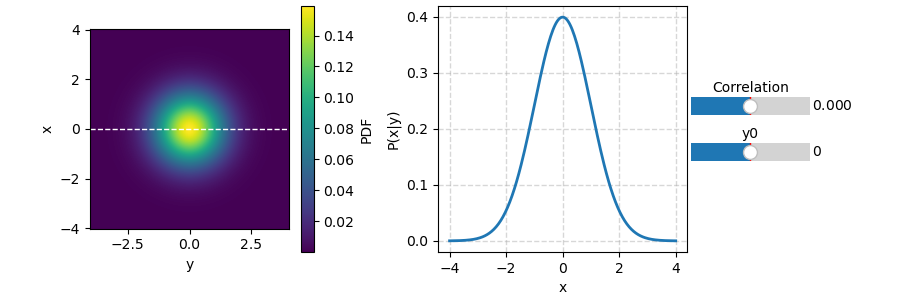

In [11]:
fig = mplt.figure(figsize=(9, 3))
gd = mplt.GridSpec(
    1, 2, right=0.9, bottom=0.16, top=0.98, left=0.1, hspace=0.02, wspace=0.01,
    width_ratios=[5, 1])
gds1 = gd[0, 0].subgridspec(1, 2, width_ratios=[1, 1], wspace=0.4)
gds = gd[0, 1].subgridspec(4, 1, height_ratios=[2, 1, 1, 2])
ax = fig.add_subplot(gds1[0, 0])
ay = fig.add_subplot(gds1[0, 1])

axcorr = fig.add_subplot(gds[1, 0])
axy0 = fig.add_subplot(gds[2, 0])
scorr = mplwid.Slider(axcorr, 'Correlation', -0.999, 0.999, valinit=0)
sy0 = mplwid.Slider(axy0, 'y0', -4, 4, valinit=0)

scorr.label.set_position((0.5, 1))
scorr.label.set_horizontalalignment('center')
sy0.label.set_position((0.5, 1))
sy0.label.set_horizontalalignment('center')

ax.set_ylabel('x')
ax.set_xlabel('y')
ax.grid(False)
ax.set_aspect('equal')
ay.set_xlabel('x')
ay.set_ylabel('P(x|y)')

# Define the grid of x and y values
y = np.linspace(-4, 4, 200)
y1, y2 = np.meshgrid(y, y)
pos = np.empty(y1.shape + (2,))
pos[:, :, 0] = y1
pos[:, :, 1] = y2

mean = np.array([0.0, 0.0])
pos -= mean

surf = ax.pcolormesh(y1, y2, y2)
hlin = ax.axline((0, 0), (1, 0), lw=1, ls='--', color='k')
lin, = ay.plot(y, y)
fig.colorbar(surf, label='PDF')

def plot_gauss(correlation=0, y0=0):
    correlation = scorr.val
    y0 = sy0.val

    # Define the covariance of the distribution
    cov = np.eye(2)
    cov[0, 1] = correlation
    cov[1, 0] = correlation

    # Calculate the inverse of the covariance matrix
    covi = np.linalg.inv(cov)

    # Calculate the multivariate Gaussian distribution
    
    pdf = np.exp(-1/2 * np.sum(pos @ covi * pos, axis=-1))
    pdf *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov))
    
    sigx = cov[0, 0] - correlation**2/cov[1, 1]
    mux = 0 + correlation/cov[1, 1]*(y0-0)
    pdfx = np.exp(-1/2 * (y-mux)**2/sigx**2)
    pdfx /= np.sqrt(2 * np.pi * sigx**2)
    lin.set_data(y, pdfx)
    ay.relim()
    ay.autoscale_view()
    
    global hlin
    hlin.remove()
    hlin = ax.axline((0, y0), (1, y0), lw=1, ls='--', color='w')
    surf.set_array(pdf)
    surf.set_clim([pdf.min(), pdf.max()])
    fig.canvas.draw_idle()

scorr.on_changed(plot_gauss)
sy0.on_changed(plot_gauss)
plot_gauss()
fig.show()

In [12]:
mplt.close(fig)

### Affine Transformation

An affine transformation of a random variable $\vect{x}\in\mathbb{R}^N$ into another random variable $\vect{y}\in\mathbb{R}^M$ is defined by:

$$ \vect{y} = \vect{c} + \vect{B}\vect{x}$$

where $\vect{c} \in \mathbb{R}^M$ and $\vect{B}\in\mathbb{R}^M\times\mathbb{R}^N$ are constants.

Given that $\vect{x}$ is distributed normally, $\vect{x}\sim\mathcal{N}(\vect{\mu_x},\, \vect{\Sigma})$, then $\vect{y}$ will also be distributed normally:

$\vect{y}\sim\mathcal{N}(\vect{c} + \vect{B}\vect{\mu_x},\, \vect{B}\vect{\Sigma}\vect{B}^T)$


As an example, let's look to the 2D case below, where $\vect{B}=(a, b)$, with $a,b\in\mathbb{R}$:

<IPython.core.display.Javascript object>


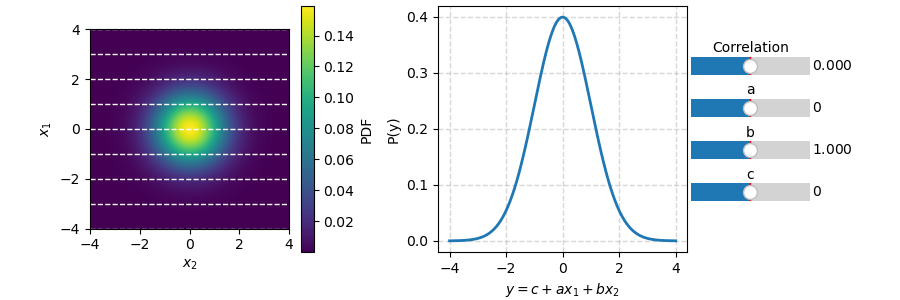

In [13]:
fig = mplt.figure(figsize=(9, 3))
gd = mplt.GridSpec(
    1, 2, right=0.9, bottom=0.16, top=0.98, left=0.1, hspace=0.02, wspace=0.01,
    width_ratios=[5, 1])
gds1 = gd[0, 0].subgridspec(1, 2, width_ratios=[1, 1], wspace=0.4)
gds = gd[0, 1].subgridspec(6, 1, height_ratios=[1, 1, 1, 1, 1, 1])
ax = fig.add_subplot(gds1[0, 0])
ax.set_aspect('equal')
ay = fig.add_subplot(gds1[0, 1])

axcorr = fig.add_subplot(gds[1, 0])
aa = fig.add_subplot(gds[2, 0])
ab = fig.add_subplot(gds[3, 0])
ac = fig.add_subplot(gds[4, 0])
scorr = mplwid.Slider(axcorr, 'Correlation', -0.999, 0.999, valinit=0)
sa = mplwid.Slider(aa, 'a', -2, 2, valinit=0)
sb = mplwid.Slider(ab, 'b', 0.001, 2, valinit=1.0)
sc = mplwid.Slider(ac, 'c', -4, 4, valinit=0)

scorr.label.set_position((0.5, 1))
scorr.label.set_horizontalalignment('center')
sa.label.set_position((0.5, 1))
sa.label.set_horizontalalignment('center')
sb.label.set_position((0.5, 1))
sb.label.set_horizontalalignment('center')
sc.label.set_position((0.5, 1))
sc.label.set_horizontalalignment('center')

ax.set_ylabel('$x_1$')
ax.set_xlabel('$x_2$')
ax.grid(False)
ay.set_xlabel('$y = c + ax_1 + bx_2$')
ay.set_ylabel('P(y)')

# Define the grid of x and y values
y = np.linspace(-4, 4, 200)
y1, y2 = np.meshgrid(y, y)
pos = np.empty(y1.shape + (2,))
pos[:, :, 0] = y1
pos[:, :, 1] = y2

mean = np.array([0.0, 0.0])
pos -= mean

surf = ax.pcolormesh(y1, y2, y2)
hlins = [
    ax.axline((0, 0), slope=0, lw=1, ls='--', color='k')
    for yi in np.linspace(-8, 8, 17)]
lin, = ay.plot(y, y)
fig.colorbar(surf, label='PDF')

def plot_gauss(correlation=0, a=0, b=0.5, c=0):
    correlation = scorr.val
    a = sa.val
    b = sb.val
    c = sc.val
    # Code done by chatgpt with a few modifications

    # Define the covariance of the distribution
    cov = np.eye(2)
    cov[0, 1] = correlation
    cov[1, 0] = correlation

    # Calculate the inverse of the covariance matrix
    covi = np.linalg.inv(cov)

    # Calculate the multivariate Gaussian distribution
    
    pdf = np.exp(-1/2 * np.sum(pos @ covi * pos, axis=-1))
    pdf *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov))
    
    B = np.array([a, b])
    sigy = B @ cov @ B.T
    muy = c + B @ np.array([0, 0])
    pdfy = np.exp(-1/2 * (y-muy)**2/sigy**2)
    pdfy /= np.sqrt(2 * np.pi * sigy**2)
    lin.set_data(y, pdfy)
    ay.relim()
    ay.autoscale_view()
    
    global hlins
    _ = [h.remove() for h in hlins]
    hlins = [
        ax.axline((0, (yi-c)/b), slope=-a/b, lw=1, ls='--', color='w')
        for yi in np.linspace(-8, 8, 17)]
    surf.set_array(pdf)
    surf.set_clim([pdf.min(), pdf.max()])
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    fig.canvas.draw_idle()

scorr.on_changed(plot_gauss)
sa.on_changed(plot_gauss)
sb.on_changed(plot_gauss)
sc.on_changed(plot_gauss)
plot_gauss()
fig.show()

In [14]:
mplt.close(fig)

### Product of two distributions

The multivariate gaussian is also closed under multiplication. 

Given two normal distributions

$$\mathcal{N}(\vect{\mu_1},\, \vect{\Sigma_1})\quad\mathcal{N}(\vect{\mu_2},\, \vect{\Sigma_2}),$$

the product between them is also a gaussian:

$$\mathcal{N}(\vect{\mu_3},\, \vect{\Sigma_3})=\mathcal{N}(\vect{\mu_1},\, \vect{\Sigma_1})\mathcal{N}(\vect{\mu_2},\, \vect{\Sigma_2}),$$

where

$$\vect{\Sigma_3} = \vect{\Sigma_1}\left(\vect{\Sigma_1} + \vect{\Sigma_2}\right)^{-1}\vect{\Sigma_2}$$
$$\vect{\mu_3} = 
\vect{\Sigma_2}\left(\vect{\Sigma_1} + \vect{\Sigma_2}\right)^{-1}\vect{\mu_1} + 
\vect{\Sigma_1}\left(\vect{\Sigma_1} + \vect{\Sigma_2}\right)^{-1}\vect{\mu_2}.$$

Let's again look at a 2D example:

<IPython.core.display.Javascript object>


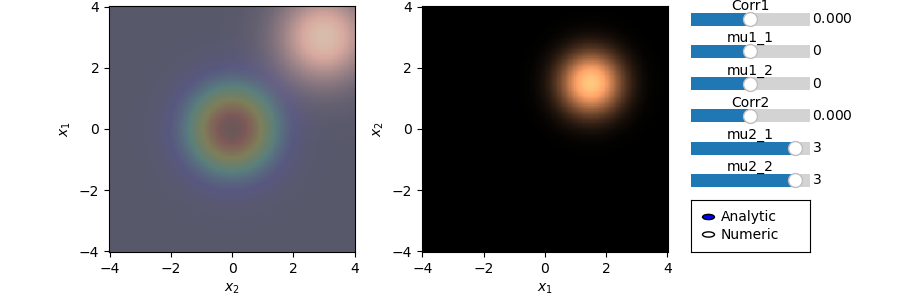

In [15]:
fig = mplt.figure(figsize=(9, 3))
gd = mplt.GridSpec(
    1, 2, right=0.9, bottom=0.16, top=0.98, left=0.1, hspace=0.02, wspace=0.01,
    width_ratios=[5, 1])
gds1 = gd[0, 0].subgridspec(1, 2, width_ratios=[1, 1], wspace=0.1)
gds = gd[0, 1].subgridspec(7, 1, height_ratios=[1, 1, 1, 1, 1, 1, 2])
ax = fig.add_subplot(gds1[0, 0])
ay = fig.add_subplot(gds1[0, 1])

axcorr1 = fig.add_subplot(gds[0, 0])
amu11 = fig.add_subplot(gds[1, 0])
amu12 = fig.add_subplot(gds[2, 0])
axcorr2 = fig.add_subplot(gds[3, 0])
amu21 = fig.add_subplot(gds[4, 0])
amu22 = fig.add_subplot(gds[5, 0])
aclc = fig.add_subplot(gds[6, 0])

scorr1 = mplwid.Slider(axcorr1, 'Corr1', -0.999, 0.999, valinit=0)
scorr2 = mplwid.Slider(axcorr2, 'Corr2', -0.999, 0.999, valinit=0)
smu11 = mplwid.Slider(amu11, 'mu1_1', -4, 4, valinit=0)
smu12 = mplwid.Slider(amu12, 'mu1_2', -4, 4, valinit=0)
smu21 = mplwid.Slider(amu21, 'mu2_1', -4, 4, valinit=3)
smu22 = mplwid.Slider(amu22, 'mu2_2', -4, 4, valinit=3)
sclc = mplwid.RadioButtons(aclc, ['Analytic', 'Numeric'], active=0)

scorr1.label.set_position((0.5, 1))
scorr1.label.set_horizontalalignment('center')
scorr2.label.set_position((0.5, 1))
scorr2.label.set_horizontalalignment('center')
smu11.label.set_position((0.5, 1))
smu11.label.set_horizontalalignment('center')
smu12.label.set_position((0.5, 1))
smu12.label.set_horizontalalignment('center')
smu21.label.set_position((0.5, 1))
smu21.label.set_horizontalalignment('center')
smu22.label.set_position((0.5, 1))
smu22.label.set_horizontalalignment('center')

ax.set_ylabel('$x_1$')
ax.set_xlabel('$x_2$')
ax.grid(False)
ax.set_aspect('equal')
ay.set_xlabel('$x_1$')
ay.set_ylabel('$x_2$')
ay.grid(False)
ay.set_aspect('equal')

# Define the grid of x and y values
y = np.linspace(-4, 4, 200)
y1, y2 = np.meshgrid(y, y)
pos = np.empty(y1.shape + (2,))
pos[:, :, 0] = y1
pos[:, :, 1] = y2

surf1 = ax.pcolormesh(y1, y2, y2, alpha=0.3, cmap='jet')
surf2 = ax.pcolormesh(y1, y2, y2, alpha=0.5, cmap='copper')
surf3 = ay.pcolormesh(y1, y2, y2, alpha=1, cmap='jet')

def plot_gauss(
        corr1=0, mu1_1=0, mu1_2=0,
        corr2=0, mu2_1=0, mu2_2=0,
        calculated=False):
    corr1 = scorr1.val
    corr2 = scorr2.val
    mu1_1 = smu11.val
    mu1_2 = smu12.val
    mu2_1 = smu21.val
    mu2_2 = smu22.val
    calculated = bool(sclc.active)
    # Code done by chatgpt with a few modifications

    # Define the covariance of the distribution
    mu1 = np.array([mu1_1, mu1_2])
    cov1 = np.eye(2)
    cov1[0, 1] = corr1
    cov1[1, 0] = corr1

    mu2 = np.array([mu2_1, mu2_2])
    cov2 = np.eye(2)
    cov2[0, 1] = corr2
    cov2[1, 0] = corr2

    inv = np.linalg.inv(cov1 + cov2)
    cov3 = cov1 @ inv @ cov2
    mu3 = cov2 @ inv @ mu1 + cov1 @ inv @ mu2
    
    # Calculate the inverse of the covariance matrix
    cov1i = np.linalg.inv(cov1)
    cov2i = np.linalg.inv(cov2)
    cov3i = np.linalg.inv(cov3)

    # Calculate the multivariate Gaussian distribution
    pdf1 = np.exp(-1/2 * np.sum((pos-mu1) @ cov1i * (pos-mu1), axis=-1))
    pdf1 *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov1))
    
    pdf2 = np.exp(-1/2 * np.sum((pos-mu2) @ cov2i * (pos-mu2), axis=-1))
    pdf2 *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov2))
    
    if calculated:
        pdf3 = np.exp(-1/2 * np.sum((pos-mu3) @ cov3i * (pos-mu3), axis=-1))
        pdf3 *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov3))
        surf3.set_cmap('copper')
    else:
        pdf3 = pdf1 * pdf2
        surf3.set_cmap('jet')
    
    surf1.set_array(pdf1)
    surf1.set_clim([pdf1.min(), pdf1.max()])

    surf2.set_array(pdf2)
    surf2.set_clim([pdf2.min(), pdf2.max()])

    surf3.set_array(pdf3)
    surf3.set_clim([pdf3.min(), pdf3.max()])

    fig.canvas.draw_idle()
    
scorr1.on_changed(plot_gauss)
scorr2.on_changed(plot_gauss)
smu11.on_changed(plot_gauss)
smu12.on_changed(plot_gauss)
smu21.on_changed(plot_gauss)
smu22.on_changed(plot_gauss)
sclc.on_clicked(plot_gauss)
plot_gauss()
fig.show()

In [16]:
mplt.close(fig)

Note that all the properties described above can be calculated using very basic linear algebra, which implies that almost everything involving gaussians is very easy and fast to evaluate.

These properties are the main reason gaussians are used everywhere in statistics, mainly in Bayesian Inference.

What generally requires integration in a high dimensional space with other distributions can be accomplished with a few matrix multiplications when gaussians are used. 

## A Different Way to Visualize Samples from Multivariate Distributions

In order to build a more intuitive view of a gaussian process, let's first remember the multivariate gaussian distribution:

$$\vect{y} \sim \mathcal{N}(\vect{\mu}, \vect{\Sigma}) = \frac{1}{\sqrt{(2\pi)^N|\vect{\Sigma}|}}\exp\left(-\frac12(\vect{y}-\vect{\mu})^T\vect{\Sigma}^{-1}(\vect{y}-\vect{\mu})\right)$$

whose symbols meaning are the same as discussed previously.

The usual way of visualizing this distribution is by plotting its PDF or drawing samples from the distribution and plotting one versus another.

In the example below we will visualize a 2D gaussian differently. This approach will help us see the influence of the covariance between the random variables and extend the visualization into higher dimensions.

Notice that when we increase the correlation between both variables the slope of lines on the right become smaller and the line approaches the horizontal line. On the other hand, when we make a high negative correlation the slopes become closer to $\pm1$.

<IPython.core.display.Javascript object>


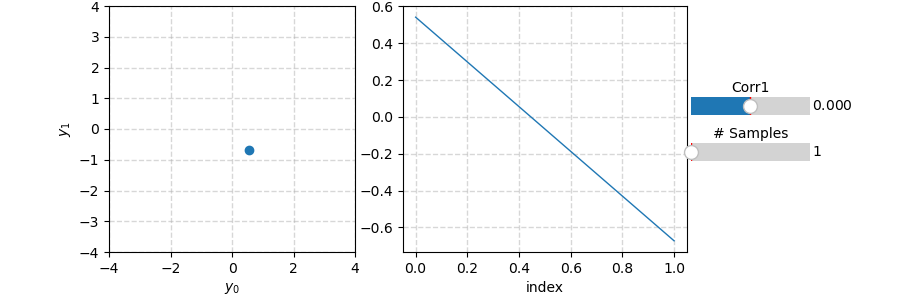

In [17]:
fig = mplt.figure(figsize=(9, 3))
gd = mplt.GridSpec(
    1, 2, right=0.9, bottom=0.16, top=0.98, left=0.1, hspace=0.02, wspace=0.01,
    width_ratios=[5, 1])
gds1 = gd[0, 0].subgridspec(1, 2, width_ratios=[1, 1], wspace=0.1)
gds = gd[0, 1].subgridspec(4, 1, height_ratios=[2, 1, 1, 2])
ax = fig.add_subplot(gds1[0, 1])
ay = fig.add_subplot(gds1[0, 0])

acorr = fig.add_subplot(gds[1, 0])
anrs = fig.add_subplot(gds[2, 0])

scorr = mplwid.Slider(acorr, 'Corr1', -0.999, 0.999, valinit=0)
snrs = mplwid.Slider(anrs, '# Samples', 1, 300, valinit=1)

scorr.label.set_position((0.5, 1))
scorr.label.set_horizontalalignment('center')
snrs.label.set_position((0.5, 1))
snrs.label.set_horizontalalignment('center')

ax.set_ylabel('y')
ax.set_xlabel('index')

line, = ay.plot([0], [0], 'o')
ay.set_ylabel(r'$y_1$')
ay.set_xlabel(r'$y_0$')
ay.set_aspect('equal')
ay.set_xlim([-4, 4])
ay.set_ylim([-4, 4])

def plot_gauss(correlation=0, n_samples=1):
    correlation = scorr.val
    n_samples = int(snrs.val)
    [l.remove() for l in ax.lines]
    x = np.linspace(0, 1, 2)
    cov = np.eye(2)
    cov[0, 1] = correlation
    cov[1, 0] = correlation
    mean = np.zeros(x.size)
    data = np.random.multivariate_normal(mean, cov, size=n_samples)
    ax.plot(x, data.T, lw=1)
    ax.relim()
    ax.autoscale_view()
    line.set_data(data[:, 0], data[:, 1])
    fig.canvas.draw_idle()

scorr.on_changed(plot_gauss)
snrs.on_changed(plot_gauss)
plot_gauss()
fig.show()

In [18]:
mplt.close(fig)

When we go to higher dimensions it is difficult to visualize the variables the same way we did on the left, but the graph on the right can be readly applied for an arbitrary number of dimensions.

In the figure below we plot five samples of the $N$-dimensional vector of random variables as function of the coordinate index $i$. Note how the curves change as we increase the correlation between the several coordinates:

<IPython.core.display.Javascript object>


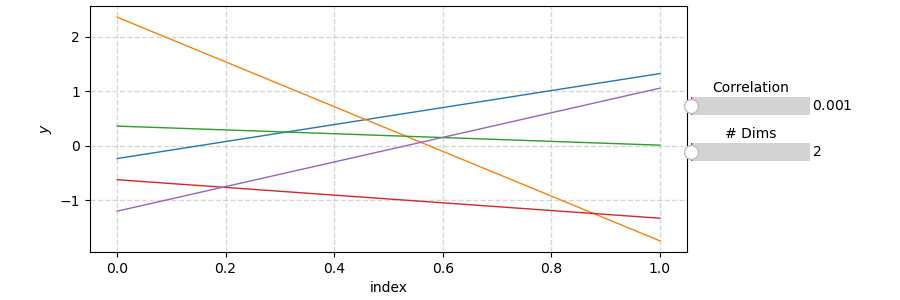

In [19]:
fig = mplt.figure(figsize=(9, 3))
gd = mplt.GridSpec(
    1, 2, right=0.9, bottom=0.16, top=0.98, left=0.1, hspace=0.02, wspace=0.01,
    width_ratios=[5, 1])
gds = gd[0, 1].subgridspec(4, 1, height_ratios=[2, 1, 1, 2])
ax = fig.add_subplot(gd[0, 0])

acorr = fig.add_subplot(gds[1, 0])
andim = fig.add_subplot(gds[2, 0])

scorr = mplwid.Slider(acorr, 'Correlation', 0.001, 0.999, valinit=0.001)
sndim = mplwid.Slider(andim, '# Dims', 2, 300, valinit=2)

scorr.label.set_position((0.5, 1))
scorr.label.set_horizontalalignment('center')
sndim.label.set_position((0.5, 1))
sndim.label.set_horizontalalignment('center')

ax.set_ylabel(r'$y$')
ax.set_xlabel('index')

def plot_gauss(correlation=1e-3, ndim=2):
    correlation = scorr.val
    ndim = sndim.val
    ncurves=5
    [l.remove() for l in ax.lines]
    x = np.arange(ndim, dtype=float)/ndim*10
    cov = lib.KernelFuncs.squared_exponential(x, x, leng=correlation)
    mean = np.zeros(x.size)
    data = np.random.multivariate_normal(mean, cov, size=ncurves)
    ax.plot(data.T, lw=1)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw_idle()

scorr.on_changed(plot_gauss)
sndim.on_changed(plot_gauss)
plot_gauss()
fig.show()

In [20]:
mplt.close(fig)

I was not completely honest in the graph above, because when we are in 2 dimensions there is only one way we can increase the correlation between the two variables. However when we go to higher dimensions, $N$, there are $N(N-1)/2$ free coefficients in the covariance matrix to define the covariance between each pair of coordinates. In the graph above I changed the covariance matrix in a very specific way:

$$\Sigma_{ij} = K(i, j) := \exp\left(-\frac12\left(\frac{i-j}{Nl}\right)^2\right)$$

where $K(i,j)$ is called kernel function and $l$ is the variable we change in the knob of the graphic.

Note that the self-correlation, or the variance of every varible, is $K(i, i)=\exp(0)=1$ and the correlation between variables decays as they are more apart in the index set.

If I used another kernel we would have a very different figure. For example, consider the following covariance matrix:

$$\Sigma_{ij} = K(i, j) := \exp\left(-\frac{|i-j|}{Nl}\right)$$

we get the following behavior:

<IPython.core.display.Javascript object>


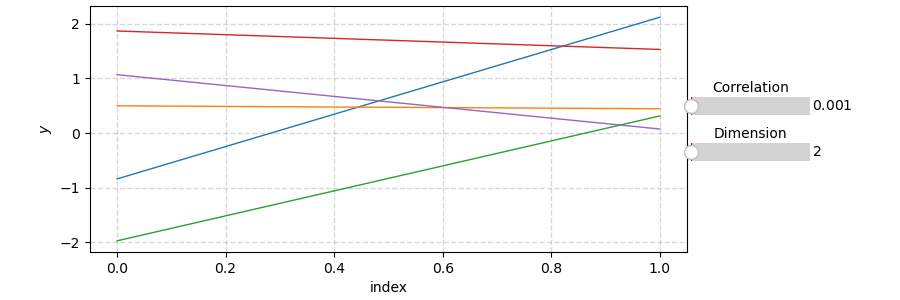

In [21]:
fig = mplt.figure(figsize=(9, 3))
gd = mplt.GridSpec(
    1, 2, right=0.9, bottom=0.16, top=0.98, left=0.1, hspace=0.02,
    wspace=0.01, width_ratios=[5, 1])
gds = gd[0, 1].subgridspec(4, 1, height_ratios=[2, 1, 1, 2])
ax = fig.add_subplot(gd[0, 0])

acorr = fig.add_subplot(gds[1, 0])
andim = fig.add_subplot(gds[2, 0])

scorr = mplwid.Slider(acorr, 'Correlation', 0.001, 0.999, valinit=0.001)
sndim = mplwid.Slider(andim, 'Dimension', 2, 300, valinit=2)

scorr.label.set_position((0.5, 1))
scorr.label.set_horizontalalignment('center')
sndim.label.set_position((0.5, 1))
sndim.label.set_horizontalalignment('center')

ax.set_ylabel(r'$y$')
ax.set_xlabel('index')

def plot_gauss(correlation=1e-3, ndim=2):
    correlation = scorr.val
    ndim = sndim.val
    ncurves=5
    [l.remove() for l in ax.lines]
    x = np.arange(ndim, dtype=float)/ndim*10
    cov = lib.KernelFuncs.exponential(x, x, leng=correlation)
    mean = np.zeros(x.size)
    data = np.random.multivariate_normal(mean, cov, size=ncurves)
    ax.plot(data.T, lw=1)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw_idle()

scorr.on_changed(plot_gauss)
sndim.on_changed(plot_gauss)
plot_gauss()
fig.show()

In [22]:
mplt.close(fig)

which is continuous but not differentiable and is compatible with the brownian motion of a particle.

# Bayes Theorem and Bayesian Inference

Suppose we have a physical quantity $y$ whose value we don't know but we think it is distributed normally with $\sigma=3$. Since we don't know the value, we assume $\mu=0$. The PDF of this variable is given by:

$$P(y|\mu=0,\sigma=3) = \mathcal{N}(0,3) = \frac{1}{3\sqrt{2\pi}}\exp\left(-\frac12\frac{y^2}{3^2}\right)$$

In [8]:
# Code made by chatgpt with a few modifications

# Define the prior mean and standard deviation
mu_0 = 0
sigma_0 = 3

# Define a range of X values
X = np.linspace(-20, 20, 10000)

# Calculate the prior PDF
prior_pdf = scystat.norm.pdf(X, mu_0, sigma_0)

<IPython.core.display.Javascript object>


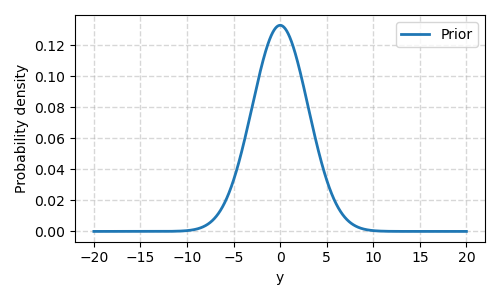

In [9]:
# Plot the prior PDF
fig, ax = mplt.subplots(1, 1, figsize=(5, 3))
ax.plot(X, prior_pdf, label='Prior')
ax.set_xlabel('y')
ax.set_ylabel('Probability density')
ax.legend(loc='best')
fig.tight_layout()
fig.show()

In [10]:
mplt.close(fig)

Now suppose we make a measurement $y_0$ of this quantity and the value is $5$. The measurement procedure has an uncertainty whose standard deviation is $1$. We could say that the result of the measurement also is a gaussian:

$$P(y_0|y, \mu_0=5, \sigma_0=1) = \mathcal{N}(5, 1) = \frac{1}{1\sqrt{2\pi}}\exp\left(-\frac12\frac{(y_0-5)^2}{1^2}\right)$$

we can use Bayes Theorem to update our beliefs given this new information:

$$P(y|y_0) = \frac{P(y_0|y)P(y)}{P(y_0)}$$

where :
 - $P(y|y_0)$ is called the posterior, because it represents our updated beliefs on $y$ after the measurement;
 - $P(y)=P(y|\mu,\sigma)$ is our prior assumption;
 - $P(y_0|y)$ called likelihood, which in our case is the measurement information;
 - $P(y_0)$ is the probability of having measured $y_0$ (marginal likelihood) which here we can consider just as a normalization constant

In [11]:
# Define the measurement mean and standard deviation
mu_x = [5, 1, 3, 2, 3.5]
sigma_x = [1, 4, 1.5, 2, 0.5]
frames = list(range(len(mu_x)))

<IPython.core.display.Javascript object>


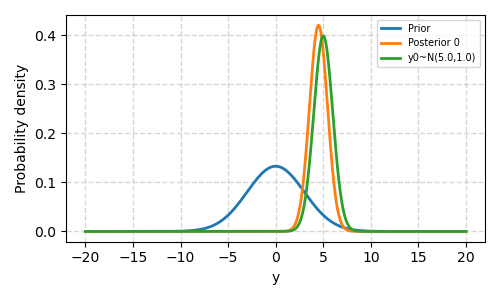

In [12]:
anim, fig = lib.Animate.bayes(frames[:1], mu_x, sigma_x, X, prior_pdf)

In [13]:
mplt.close(fig)

If more data is measured our beliefs can be updated considering the previous posterior distribution as prior:

$$P(y|\{y_0,y_1\}) = \frac{P(y_1|y)P(y|y_0)}{P(y_1)} = \frac{P(y_1|y)P(y_0|y)P(y)}{P(y_1)P(y_0)}$$

This process can be repeated indefinetly considering new measurements are made:

$$P(y|\mathcal{D}) = \frac{\prod_\mathcal{D}P(y_i|y)}{\prod_\mathcal{D}P(y_i)}P(y), \quad \mathcal{D}=\{y_i| i=0..N\} \quad\mathrm{and}\quad y_i \sim \mathcal{N}(\mu_i, \sigma_i)$$

<IPython.core.display.Javascript object>


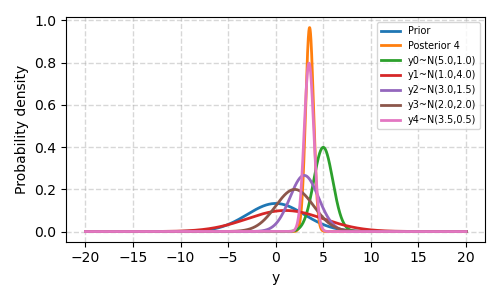

In [14]:
# # Local example:
# mu_x = np.random.randn(10)*3 + 4
# sigma_x = np.ones(mu_x.size)*1

# prior_pdf = scystat.norm.pdf(X, 2, 7)
# frames = list(range(len(mu_x)))

anim, fig = lib.Animate.bayes(frames, mu_x, sigma_x, X, prior_pdf)

In [15]:
mplt.close(fig)

It is worth noticing that the final posterior does not depend on the order of the new data:

<IPython.core.display.Javascript object>


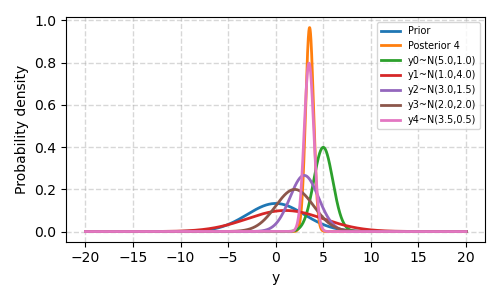

In [16]:
anim2, fig = lib.Animate.bayes(
    np.random.permutation(frames), mu_x, sigma_x, X, prior_pdf)

In [17]:
mplt.close(fig)

# Parametric Regression

As an example let's see how we could use the framework defined above to perform parametric regression of some curves.

First, let's start with the simple straight line model:

$$ f(x) = \omega_1 + \omega_2x = \vect{\phi}(x)^T\vect{\omega}$$

where $\vect{\omega} \in \mathbb{R}^2$ is the vector of random variables we want to know more about and $\vect{\phi}(x) = (1, x)^T$. When we look this way we see that the function is a random variable defined by the affine transformation $\vect{\phi}(x)$ of $\vect{\omega}$.

Now lets assume a gaussian prior on $\vect{\omega}$:

$$ \vect{\omega} \sim \mathcal{N}\left(\vect{\bar{\omega}}, \vect{\Sigma}\right)$$

Considering that f is just a linear combination of $\vect{\omega}$, the prior on $f(x)$ is given by:

$$ f(x) \sim \mathcal{N}\left(\vect{\phi}^T\vect{\bar{\omega}},\,\, \vect{\phi}^T\vect{\Sigma}\vect{\phi}\right)$$

The figure below shows the general behavior of this prior:

In [18]:
# Made up data
w_truth = (1, 2)
feat_func_truth = _partial(
    lib.FeatureFuncs.polynomial, num_features=len(w_truth))
num_data = 10
sigma_err = 1
x_data = (np.random.rand(num_data)-0.5)*2 * 6
y_data = feat_func_truth(x_data) @ w_truth
y_data += np.random.randn(*x_data.shape)*sigma_err

# points for inference and truth values:
num_pts = 100
x = np.linspace(-6, 6, num_pts)
truth = (x, feat_func_truth(x)@w_truth)

In [19]:
# Prior on omega
feat_func = lib.FeatureFuncs.linear
mu_prior = np.zeros(feat_func(np.zeros(1)).shape[1])
sigma_prior = 3*np.eye(mu_prior.size)
prior = scystat.multivariate_normal(mu_prior, sigma_prior)

<IPython.core.display.Javascript object>


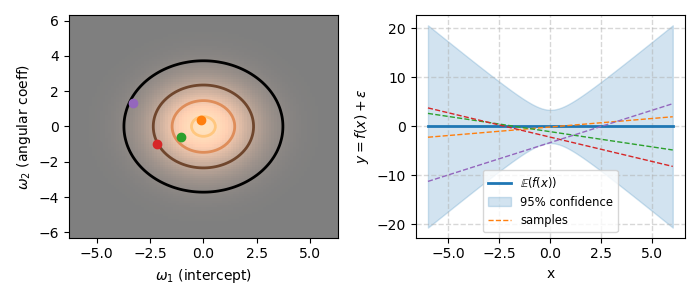

In [20]:
anim, fig = lib.Animate.parametric_distribution(x, prior, feature_func=feat_func)

In [21]:
anim.repeat=False
mplt.close(fig)

Now, suppose that a total of $N$ measurements are performed, such that:

$$\mathcal{D} = \{(x_i, y_i)| i\in[1,N]\} = (\vect{x}, \vect{y})$$

where $y_i$ represent noisy observations of the underlying function $f(x_i)$:

$$y_i = f(x_i) + \varepsilon, \quad\mathrm{with}\quad \varepsilon \sim \mathcal{N}(0,\sigma^2)$$

This way we se that the likelyhood of all the measurements is given by:

$$P(\vect{y}|\vect{\omega}, \mathcal{D}) = \prod_\mathcal{D}\frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{(y_i-\vect{\phi}(x_i)^T\vect{\omega})^2}{2\sigma^2}\right)$$

Since we are considering all measurement error distributions are equally distributed (same $\sigma^2$) and gaussian. We can simplify the equation above such that:

$$P(\vect{y}|\vect{\omega}, \mathcal{D}) = \frac{1}{(2\pi)^{N/2}\sigma^N}\exp\left(-\frac{|\vect{y}-\vect{\Phi}^T\vect{\omega}|^2}{2\sigma^2}\right)$$

where we introduced the matrix $\vect{\Phi} := (\phi(x_1),...\phi(x_i),...\phi(x_N))$.

The posterior distribution can then be updated using Bayes theorem:

$$P(\vect{\omega}|\mathcal{D}) = \frac{P(\vect{y}|\vect{x},\vect{\omega})P(\vect{\omega})}{P(\vect{y}|\vect{x})} \propto
\exp\left(-\frac{1}{2\sigma^2}\left(\vect{y}-\vect{\Phi}^T\vect{\omega}\right)^T\left(\vect{y}-\vect{\Phi}^T\vect{\omega}\right)\right)
\exp\left(-\frac12(\vect{\omega}-\vect{\bar{\omega}})^T\vect{\Sigma}^{-1}(\vect{\omega}-\vect{\bar{\omega}})\right)
$$

Since all distributions are gaussian, we can analytically compute the posterior by completing the squares on the equation above. After some math we see the posterior is also gaussian:

$$P(\vect{\omega}|\mathcal{D}) = \mathcal{N}(\vect{\bar{\omega}_p}, \vect{\Sigma_p}),
\quad \mathrm{with} \quad
\vect{\bar{\omega}_p}=
\vect{\bar{\omega}} + \frac{1}{\sigma^2}\vect{\Sigma_p}\vect{\Phi}(\vect{y}-\vect{\Phi}^T\vect{\bar{\omega}})
\quad \mathrm{and} \quad
\vect{\Sigma_p}=\left(\sigma^{-2}\vect{\Phi}\vect{\Phi}^T + \vect{\Sigma}^{-1}\right)^{-1}$$

and, consequently, the posterior on $f(x)$ is also gaussian:

$$ f(x) \sim \mathcal{N}\left(\vect{\phi}^T\vect{\bar{\omega}_p},\,\, \vect{\phi}^T\vect{\Sigma_p}\vect{\phi}\right)$$

The animation below shows the process of the regression as data is measured, point by point, and how the posteriors are updated:

<IPython.core.display.Javascript object>


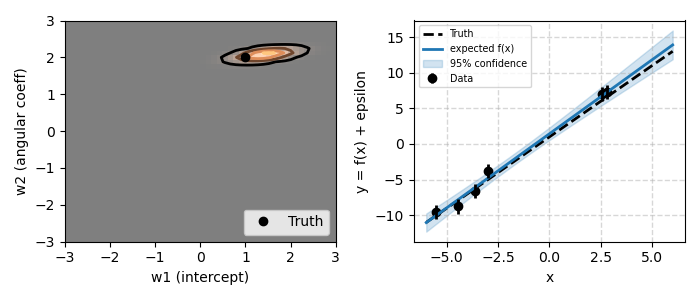

In [22]:
anim, fig = lib.Animate.parametric_regression(
    x, x_data, y_data, prior, feat_func, sigma_err, truth=w_truth)

In [23]:
anim.repeat = False
mplt.close(fig)

The animation below shows the posterior distribution and some of its samples:

<IPython.core.display.Javascript object>


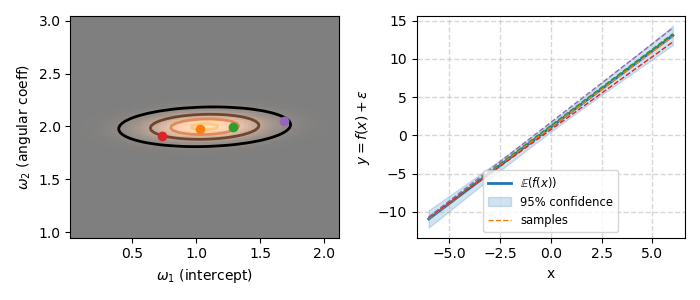

In [24]:
post = lib.Regressions.parametric_bayesian(
    x, x_data, y_data, prior, feat_func, sigma_err)
anim, fig = lib.Animate.parametric_distribution(x, post, feat_func)

In [25]:
anim.repeat = False
mplt.close(fig)

In [82]:
# Made up data
num_data = 12
sigma_err = 20
x_data = np.linspace(-5.5, 5.5, num_data)
x_data += np.random.randn(num_data)*0.2
x_data[x_data<-6] = -5.9
x_data[x_data>+6] = +5.9
x_data = np.random.permutation(x_data)
X = np.vstack([x_data, 2*np.ones(num_data)])
# y_data = np.log(lib.TestFunctions.rosenbrock(X))
y_data = lib.TestFunctions.himmelblau(X/1.2)
y_data += np.random.randn(*x_data.shape)*sigma_err

# points for inference and truth values:
num_pts = 100
x = np.linspace(-6, 6, num_pts)
X = np.vstack([x, 2*np.ones(num_pts)])
# fx = np.log(lib.TestFunctions.rosenbrock(X))
fx = lib.TestFunctions.himmelblau(X/1.2)
cov_amp = np.abs(fx).max()**2
truth = (x, fx)

In [27]:
# fig, ax = mplt.subplots(1, 1, figsize=(7, 4))

# ax.plot(x, lib.TestFunctions.styblinski(X/1.5), label='styblinski')
# ax.plot(x, lib.TestFunctions.rosenbrock(X/8), label='rosenbrock')
# ax.plot(x, lib.TestFunctions.beale(X), label='beale')
# ax.plot(x, lib.TestFunctions.himmelblau(X/1.2), label='himmelblau')
# ax.plot(x, lib.TestFunctions.eggholder(X*10), label='eggholder')
# ax.legend(loc='best')
# fig.tight_layout()
# fig.show()

In [28]:
# Prior on omega
feat_func = _partial(lib.FeatureFuncs.polynomial, num_features=5)
mu_prior = np.zeros(feat_func(np.zeros(1)).shape[1])
sigma_prior = cov_amp*np.eye(mu_prior.size)
prior = scystat.multivariate_normal(mu_prior, sigma_prior)

Notice that the formalism defined above can readly be applied to any model whose basis functions are fixed. For example, in the case of a polynomial we have:

$$f(x) = \omega_0 + \omega_1x + ... + \omega_px^p = \vect{\phi}^T\vect{\omega}$$

where now $\vect{\omega}, \vect{\phi} \in \mathbb{R}^p$ with $\phi = (1, x, ..., x^p)$ and the same equations above hold.

So that we have the prior on $\vect{\omega}$ being a $p$-dimensional multivariate gaussian:

<IPython.core.display.Javascript object>


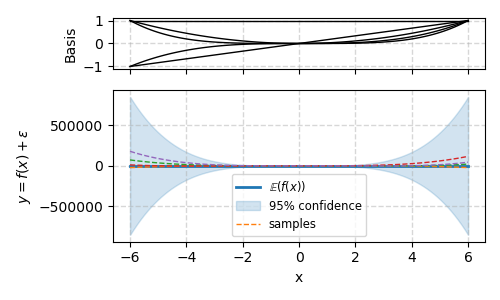

In [29]:
anim, fig = lib.Animate.parametric_distribution(x, prior, feat_func)

In [30]:
anim.repeat=False
mplt.close(fig)

The regression evolution as new data comes in is shown below:

<IPython.core.display.Javascript object>


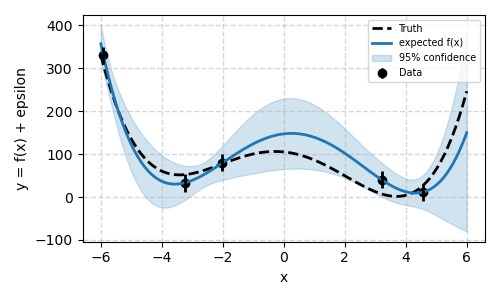

In [31]:
anim, fig = lib.Animate.parametric_regression(
    x, x_data, y_data, prior, feat_func, sigma_err, truth=truth)

In [32]:
anim.repeat = False
mplt.close(fig)

In [33]:
# Prior on omega
feat_func = _partial(lib.FeatureFuncs.sines, num_freqs=6, L=6)
mu_prior = np.zeros(feat_func(np.zeros(1)).shape[1])
sigma_prior = cov_amp*np.eye(mu_prior.size)
prior = scystat.multivariate_normal(mu_prior, sigma_prior)

The same idea also applies when the basis functions are not polynomials. For example, in case they are sines and cossines:

$$\vect{\phi} = \left(1,
    \sin\left(\frac{2\pi x}{L}\right), ..., \sin\left(\frac{2\pi px}{L}\right),
    \cos\left(\frac{2\pi x}{L}\right), ..., \cos\left(\frac{2\pi px}{L}\right)\right)^T$$

where $L\in\mathbb{R}$ is a constant.

We have the following prior:

<IPython.core.display.Javascript object>


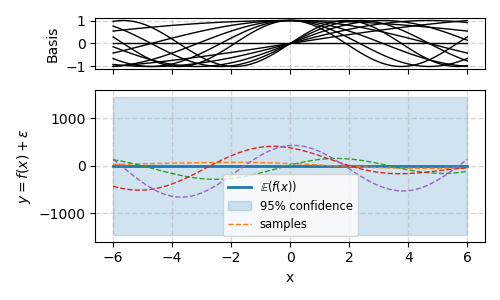

In [34]:
anim, fig = lib.Animate.parametric_distribution(x, prior, feat_func)

In [35]:
anim.repeat=False
mplt.close(fig)

The regression process is shown below:

<IPython.core.display.Javascript object>


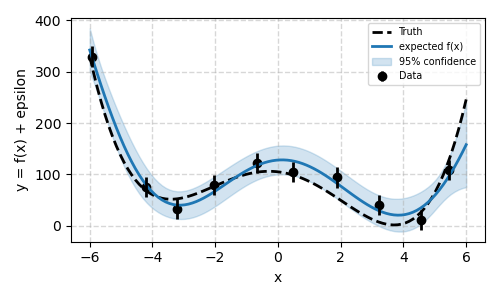

In [36]:
anim, fig = lib.Animate.parametric_regression(
    x, x_data, y_data, prior, feat_func, sigma_err, truth=truth)

In [37]:
anim.repeat = False
mplt.close(fig)

In [38]:
# Prior on omega
feat_func = _partial(lib.FeatureFuncs.steps, step_range=6)
mu_prior = np.zeros(feat_func(np.zeros(1)).shape[1])
sigma_prior = cov_amp*np.eye(mu_prior.size)
prior = scystat.multivariate_normal(mu_prior, sigma_prior)

Discontinue functions are also an option. For example, in case they step functions:

$$\vect{\phi} = (\Theta(x-a_0),..., \Theta(x-a_p))^T, \,\, \mathrm{with}\,\,
\Theta(x) = \left\{\begin{matrix}-1 & x<0 \\ 0 & x = 0 \\ 1 & x>0\end{matrix}\right.$$

where $a_i\in\mathbb{R}$ for $i\in[0,p]\}$ are constants.

We have the following prior:

<IPython.core.display.Javascript object>


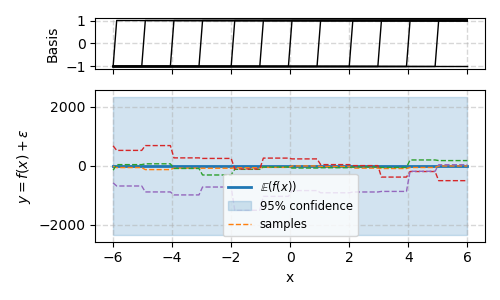

In [39]:
anim, fig = lib.Animate.parametric_distribution(x, prior, feat_func)

In [40]:
anim.repeat=False
mplt.close(fig)

And the regression looks like:

<IPython.core.display.Javascript object>


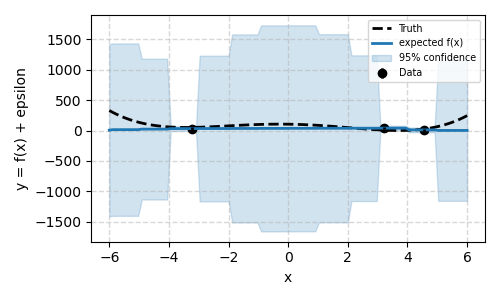

In [41]:
anim, fig = lib.Animate.parametric_regression(
    x, x_data, y_data, prior, feat_func, sigma_err, truth=truth)

In [42]:
anim.repeat = False
mplt.close(fig)

In [43]:
# Prior on omega
feat_func = _partial(lib.FeatureFuncs.gauss, mean_range=6, sigma=2)
mu_prior = np.zeros(feat_func(np.zeros(1)).shape[1])
sigma_prior = cov_amp*np.eye(mu_prior.size)
prior = scystat.multivariate_normal(mu_prior, sigma_prior)

An interesting particular case of this formalism comes when the basis functions are equally spaced gaussian functions with the same variance:

$$\vect{\phi} = (
\exp\left(-\frac{(x-a_0)^2}{2\sigma}\right),
...,
\exp\left(-\frac{(x-a_p)^2}{2\sigma}\right),$$

where $\sigma\in\mathbb{R}$ and $a_i\in\mathbb{R}$ for $i\in[0,p]$ are both constants

Note from the prior how the samples are very smooth functions:

<IPython.core.display.Javascript object>


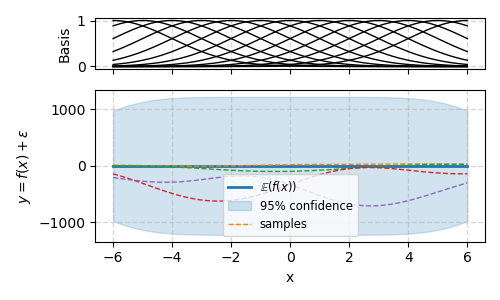

In [44]:
anim, fig = lib.Animate.parametric_distribution(x, prior, feat_func)

In [45]:
anim.repeat=False
mplt.close(fig)

Another interesting feature of this set of basis functions is that the posterior tends towards the prior away from the data, since all basis functions go to zero at $\pm\infty$:

<IPython.core.display.Javascript object>


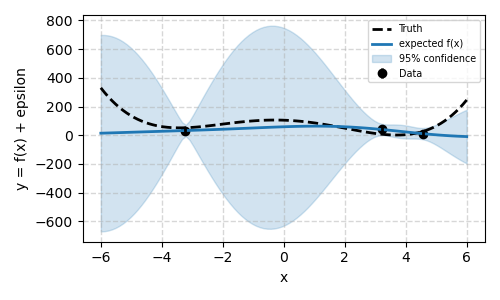

In [46]:
anim, fig = lib.Animate.parametric_regression(
    x, x_data, y_data, prior, feat_func, sigma_err, truth=truth)

In [47]:
anim.repeat = False
mplt.close(fig)

To end this section on parametric fitting it is worth writting the posterior on $f(x)$ in a different manner. First recall that the posterior on $f(x)$ is given by:

$$ f(x_*) \sim \mathcal{N}\left(\vect{\phi_*}^T\vect{\bar{\omega}_p},\,\, \vect{\phi_*}^T\vect{\Sigma_p}\vect{\phi_*}\right)
\quad \mathrm{with} \quad
\vect{\bar{\omega}_p}=\vect{\bar{\omega}} + \frac{1}{\sigma^2}\vect{\Sigma_p}\vect{\Phi}\vect{y}
\quad \mathrm{and} \quad
\vect{\Sigma_p}=\left(\sigma^{-2}\vect{\Phi}\vect{\Phi}^T + \vect{\Sigma}^{-1}\right)^{-1}$$

where we introduced $x_*$ to denote the coordinate where we want to predict $f(x)$ and $\vect{\phi_*}=\vect{\phi}(x_*)$
Using an matrix identity, we can rewrite 

$$
\vect{\phi_*}^T\vect{\bar{\omega}_p} = 
\vect{\phi_*}^T\vect{\bar{\omega}} + \frac{1}{\sigma^2}\vect{\phi_*}^T\vect{\Sigma_p}\vect{\Phi}(\vect{y}-\vect{\Phi}^T\vect{\bar{\omega}}) =
\bar{f}(x_*) + K(x_*, \vect{x})\left(K(\vect{x}, \vect{x}) + \sigma^2\vect{I}\right)^{-1}(\vect{y}-\bar{f}(\vect{x}))$$
$$
\vect{\phi_*}^T\vect{\Sigma_p}\vect{\phi_*} =
\vect{\phi_*}^T\left(\sigma^{-2}\vect{\Phi}\vect{\Phi}^T + \vect{\Sigma}^{-1}\right)^{-1}\vect{\phi_*} =
K(x_*, x_*) - K(x_*,\vect{x})\left(K(\vect{x}, \vect{x}) + \sigma^2\vect{I}\right)^{-1}K(x_*,\vect{x})^T
$$ 

where we introduced the prior mean of $f(x)$ calculated at $x_*$ as $\bar{f}(x_*) = \vect{\phi_*}^T\vect{\bar{\omega}}$ and the kernel function $K(x_i, x_j) = \vect{\phi(x_i)}^T\vect{\Sigma}\vect{\phi}(x_j)$, that calculates the correlation between different points $x_i$ and $x_j$.

To summarize, the posterior becomes:

$$f(x_*) \sim \mathcal{N}\left(
\bar{f}(x_*) + K(x_*, \vect{x})\left(K(\vect{x}, \vect{x}) + \sigma^2\vect{I}\right)^{-1}(\vect{y}-\bar{f}(\vect{x})),\,\, 
K(x_*, x_*) - K(x_*,\vect{x})\left(K(\vect{x}, \vect{x}) + \sigma^2\vect{I}\right)^{-1}K(x_*,\vect{x})^T
\right)$$


Note that written in this form, the posterior on $f(x)$ does not depend explicitly on how we parametized $f(x)$ in the first place. It only depends on how the the points where the inference is to be made, $x_*$ are correlated to themselves and to the data points, $\vect{x}$, via the kernel function $K$.

This fact gives us a hint on how to perform a non-parametric regression, being the core idea behing gaussian processes.

We will see in the next section that all examples of parametric fitting shown here in the limit of an infinite number of basis functions for special cases of a gaussian process with different kernel functions.

# Gaussian Processes

With all the arguments presented above the definition of a gaussian process is very natural.

We say that a function 

$$f(\vect{x}): \mathbb{R}^N \rightarrow \mathbb{R}$$

is described by a gaussian process:

$$f(\vect{x}) \sim \mathcal{GP}(m(\vect{x}), K(\vect{x}, \vect{x'}))$$

where 

$$m(\vect{x}): \mathbb{R}^N \rightarrow \mathbb{R}$$

$$K(\vect{x}, \vect{x'}):\mathbb{R}^N\times\mathbb{R}^N \rightarrow \mathbb{R}$$

are the prior mean function and the covariance function (kernel), if for any finite set 

$$\mathcal{D}=\{(\vect{x_i}, f(\vect{x_i})) | \,\, i\in[1,p]\} = (\vect{X}, \vect{f}(\vect{X}))$$

the values of $f(\vect{x_i})$ are distributed according to a multivariate gaussian distribution:

$$\vect{f}(\vect{X})\sim\mathcal{N}(\vect{m}(\vect{X}), \vect{K}(\vect{X}, \vect{X}))).$$

In the equations above we introduced the notations:

$$\vect{X}=(\vect{x_1},..., \vect{x_p}) \in \mathbb{R}^N\times\mathbb{R}^p$$

$$\vect{f}(\vect{X})=(f(\vect{x_1}),..., f(\vect{x_p}))^T \in \mathbb{R}^p$$

$$\vect{m}(\vect{X})=(m(\vect{x_1}),..., m(\vect{x_p}))^T \in \mathbb{R}^p$$

$$\vect{K}(\vect{X}, \vect{X})= 
\begin{pmatrix}
K(\vect{x_1}, \vect{x_1}) & \cdot & K(\vect{x_1}, \vect{x_p})\\
\vdots & \ddots & \vdots\\
K(\vect{x_p}, \vect{x_1}) & \cdot & K(\vect{x_p}, \vect{x_p})\\
\end{pmatrix}\in \mathbb{R}^p\times\mathbb{R}^p$$

to make them compatible with a matrix notation.

The covariance function is a type of kernel that creates positive-semidefinite matrices. This means that:

$$\begin{pmatrix}\vect{x_1}^T & \cdots & \vect{x_p}^T\end{pmatrix}
\begin{pmatrix} K_{11} & \cdots & K_{1p}\\\vdots &\ddots&\vdots\\ K_{p1} &\cdots& K_{pp}\end{pmatrix}
\begin{pmatrix} \vect{x_1} \\ \vdots \\ \vect{x_p} \end{pmatrix} = 
\sum_{i,j}^p K_{ij}\vect{x_i}^T\vect{x_j}(2-\delta_{ij})
\ge 0$$

$$\forall \,\,\vect{x_i} \in \mathbb{R}^N,\,\, i \in [1, p]\in \mathbb{N},\,\, K_{ij}=K_{ji}=K(\vect{x_i},\vect{x_i})$$

This means that not every kernel function is a valid covariance function.

Note that the behavior of the gaussian process is very dependent on the choice of the covariance function.

To make this influence more clear, let's check some widely used examples of covariance functions:

## Covariance Functions

Most commonly used kernels are invariance under translations, which means that:

$$K(\vect{x_1}, \vect{x_2}) = K(\vect{x_1} + \vect{d}, \vect{x_2} + \vect{d})$$.

In this case we can define the kernel as

$$K(\vect{x_1}, \vect{x_2}) =g(z)\quad \mathrm{with}\quad z = (\vect{x_1}-\vect{x_2})^T\vect{\Sigma}^{-1}(\vect{x_1}-\vect{x_2}) $$

where $\vect{\Sigma}$ is any positive semi-definite matrix. 

Generally $\vect{\Sigma}$ is chosen to be diagonal

$$\vect{\Sigma} = \begin{pmatrix}l_1^2 & & \\ & \ddots & \\ & & l_N^2\end{pmatrix}$$.

In this case, the terms $l_i, i\in[1,N]$ have interpretation of length scale of each direction of $\mathbb{R}^N$.

If the all the diagonal terms are equal $l_1 = l_2 = \cdots = l_p = l$, then the kernel is said also be isotropic:

$$K(\vect{x_1}, \vect{x_2}) =g\left(\frac{(\vect{x_1}-\vect{x_2})^T(\vect{x_1}-\vect{x_2})}{l^2}\right) = g\left(\frac{r}{l}\right)$$

Where $r$ has the usual interpretation of radius.

In the examples below we will define the kernels in this most simplified way, but keep in mind that we can recover the most general form in all of them simply replacing $r^2\rightarrow z$.


### Squared Exponential or RBF (Radial Basis Functions)

This covariance function is the most commonly used. The class of functions it encapsulates are smooth functions, which means they can be derived infinitely many times and all derivatives are continuous. The kernel function reads:

$$K(\vect{x_1}, \vect{x_2}) = \sigma^2 \exp\left(-\frac{r^2}{2 l^2}\right).$$

This kernel is the limmiting case of a parametric fitting using off-centered gaussians of same width.

Let's see below a 2D example of this kernel:

<IPython.core.display.Javascript object>


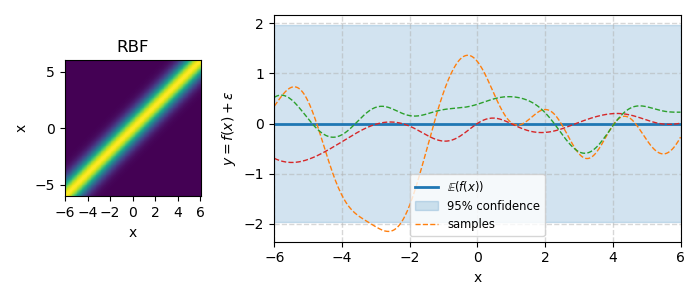

In [48]:
x = np.linspace(-6, 6, 300)
muf = np.zeros(x.shape)
cov = lib.KernelFuncs.squared_exponential(x, x, leng=1, sigma=1)
dist = scystat.multivariate_normal(muf, cov, allow_singular=True)
anim, fig = lib.Animate.gp_distribution(x, dist, 'RBF')

In [49]:
anim.repeat = False
mplt.close(fig)

### Rational Quadratic

While the squared exponential kernel has a single length scale, this kernel is the infinite sum of squared exponentials with varying length scales:

$$K(\vect{x_1}, \vect{x_2}) = \sigma^2 \left(1 + \frac1\alpha\frac{r^2}{2 l^2}\right)^{-\alpha}.$$

where $\alpha$ is a parameter that controls the distribution of length scales in kernel.

Note how in the limit $\alpha\rightarrow\infty$, we recover the squared exponential kernel.

Folow below a 2D example of this kernel. Note how the functions have varying length scales along the domain.

<IPython.core.display.Javascript object>


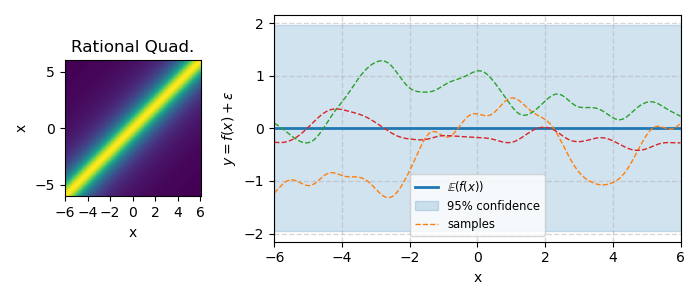

In [50]:
x = np.linspace(-6, 6, 300)
muf = np.zeros(x.shape)
cov = lib.KernelFuncs.rational_quadratic(x, x, leng=1, sigma=1)
dist = scystat.multivariate_normal(muf, cov, allow_singular=True)
anim, fig = lib.Animate.gp_distribution(x, dist, 'Rational Quad.')

In [51]:
anim.repeat = False
mplt.close(fig)

### Exponential

The class of functions it encapsulates are continuous but not differentiable functions. The kernel function reads:

$$K(\vect{x_1}, \vect{x_2}) = \sigma^2 \exp\left(-\frac{r}{l}\right).$$

The functions of this kernel are compatible with the time evolution of the velocity of a particle undergoing browniang motion.

Let's see below a 2D example of this kernel:

<IPython.core.display.Javascript object>


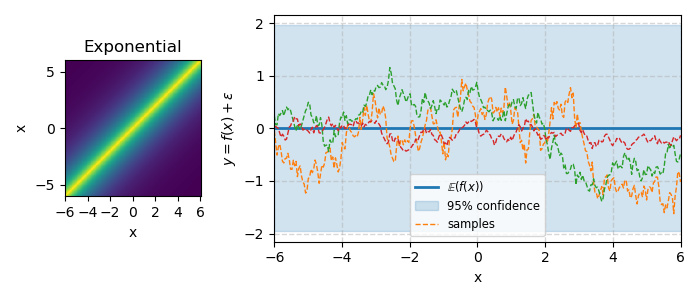

In [52]:
x = np.linspace(-6, 6, 300)
muf = np.zeros(x.shape)
cov = lib.KernelFuncs.exponential(x, x, leng=2, sigma=1)
dist = scystat.multivariate_normal(muf, cov, allow_singular=True)
anim, fig = lib.Animate.gp_distribution(x, dist, 'Exponential')

In [53]:
anim.repeat = False
mplt.close(fig)

### Sine Squared

This kernel is very useful to model periodic systems:

$$K(\vect{x_1}, \vect{x_2}) = \sigma^2 \exp\left(-\frac{2\sin^2\left(\frac{\pi r}{\lambda}\right)}{l^2}\right).$$

where $\lambda$ is the period of the correlation.

Let's see below a 2D example of this kernel:

<IPython.core.display.Javascript object>


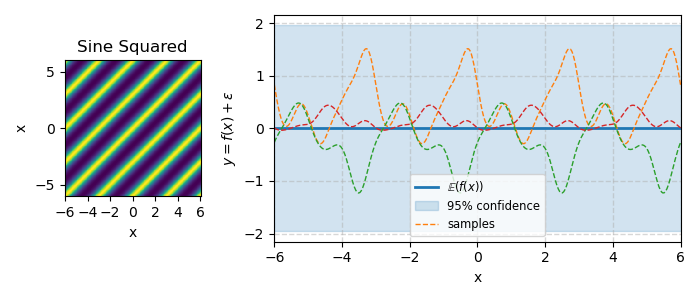

In [54]:
x = np.linspace(-6, 6, 300)
muf = np.zeros(x.shape)
cov = lib.KernelFuncs.sine_squared(x, x, leng=1, sigma=1, period=3)
dist = scystat.multivariate_normal(muf, cov, allow_singular=True)
anim, fig = lib.Animate.gp_distribution(x, dist, 'Sine Squared')

In [55]:
anim.repeat = False
mplt.close(fig)

### Matérn Kernel

The Matérn Kernels actually are a class of kernels, controlled by the parameter $\nu$:

$$K(\vect{x_1}, \vect{x_2}) = \sigma^2\frac{2^{1-\nu}}{\Gamma(\nu)}\left(\frac{\sqrt{2\nu}r}{l}\right)^\nu K_\nu\left(\frac{\sqrt{2\nu}r}{l}\right),$$

where $\Gamma(\cdot)$ is the gamma function and $K_\nu(\cdot)$ is the modified Bessel function.

Even tough the Matérn Kernel is a valid covariance function for all values of $\nu$, some particular choices are very interesting:
 - $\nu\rightarrow\infty$: squared exponential kernel;
 - $\nu=1/2$: exponential kernel;
 - $\nu=3/2$: we get a kernel which is continuous up to its first derivative. In this case the function reads:
   $$K(\vect{x_1}, \vect{x_2}) = \sigma^2\left(1 + \frac{\sqrt{3}r}{l}\right)\exp\left(-\frac{\sqrt{3}r}{l}\right)$$
   
- $\nu=5/2$: we get a kernel which is continuous up to its second derivative. In this case the function reads:
   $$K(\vect{x_1}, \vect{x_2}) = \sigma^2\left(1 + \frac{\sqrt{5}r}{l} + \frac{5r^2}{3l^2}\right)\exp\left(-\frac{\sqrt{5}r}{l}\right)$$


Let's check below the case when $\nu=3/2$.

<IPython.core.display.Javascript object>


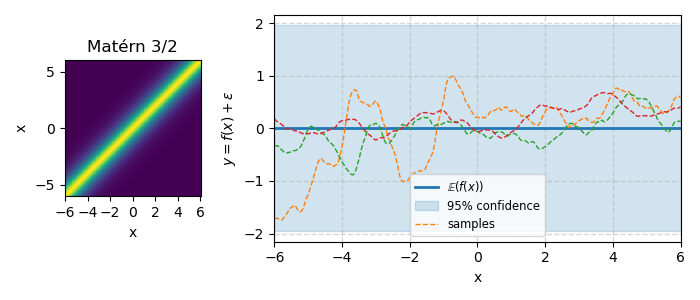

In [56]:
x = np.linspace(-6, 6, 300)
muf = np.zeros(x.shape)
cov = lib.KernelFuncs.matern3over2(x, x, leng=1, sigma=1)
dist = scystat.multivariate_normal(muf, cov, allow_singular=True)
anim, fig = lib.Animate.gp_distribution(x, dist, 'Matérn 3/2')

In [57]:
anim.repeat = False
mplt.close(fig)

### Parametric Kernel

another example of a valid kernel is the one obtained by parametric fitting. Let's remember that we can parametrize a function in terms of a set of basis functions:

$f(\vect{x}) = \vect{\phi}(\vect{x})^T \vect{\omega}, \quad \vect{\phi}(\vect{x}) = (b_1(\vect{x}), \cdots, b_p(\vect{x}))^T$$

and the parameters $\vect{\omega}$ have a prior $\mathcal{N}(\vect{0}, \vect{\Sigma_p})$.
We can define the kernel:

$$K(\vect{x_1}, \vect{x_2}) = \vect{\phi}(\vect{x_1})^T\vect{\Sigma_p}\vect{\phi}(\vect{x_2})$$

such that all the framework of parametric fitting can be translated into the gaussian process framework.

One important example of this type of kernel is the polynomial kernel:

$$K(\vect{x_1}, \vect{x_2}) = (\sigma_0 + \vect{x_1}^T\vect{x_2})^p$$

where $p$ is the order of the polynomial.

lets see a 1D example of this type of kernel, using a polynomial of order 1:

<IPython.core.display.Javascript object>


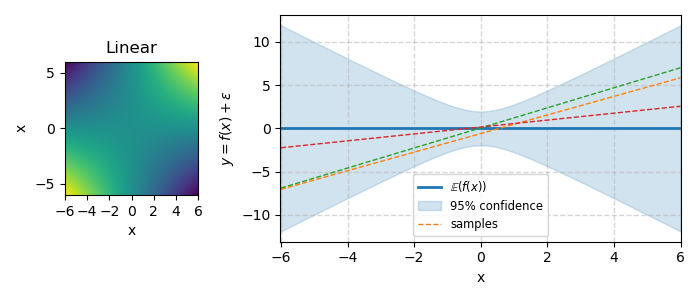

In [58]:
x = np.linspace(-6, 6, 300)
muf = np.zeros(x.shape)
feat_func = lib.FeatureFuncs.linear
cov = lib.KernelFuncs.parametric_function(x, x, feat_func, np.eye(2))
dist = scystat.multivariate_normal(muf, cov, allow_singular=True)
anim, fig = lib.Animate.gp_distribution(x, dist, 'Linear')

In [59]:
anim.repeat = False
mplt.close(fig)

### Building New Kernels from Old ones

If we have to kernels that form valid covariance functions $K_1(\vect{x_1}, \vect{x_2})$ and $K_2(\vect{x_1}, \vect{x_2})$ then:
 - the sum of the kernels is also a kernel: $K(\vect{x_1}, \vect{x_2}) = K_1(\vect{x_1}, \vect{x_2}) + K_2(\vect{x_1}, \vect{x_2})$
 - the product of the kernels is also a kernel: $K(\vect{x_1}, \vect{x_2}) = K_1(\vect{x_1}, \vect{x_2})K_2(\vect{x_1}, \vect{x_2})$
 - The application of the kernels in orthogonal subspaces is also a kernel:
 $$\vect{x} = \vect{y}\bigoplus\vect{z},\,\, \vect{y}\in\mathbb{R}^m,\,\, \vect{z}\in\mathbb{R}^n, \,\, \vect{x}\in\mathbb{R}^{m+n}\quad K(\vect{x_1}, \vect{x_2}) = K_1(\vect{y_1}, \vect{y_2}) + K_2(\vect{z_1}, \vect{z_2})$$
 
In the example below we summed the liner kernel with the squared exponential kernel:

<IPython.core.display.Javascript object>


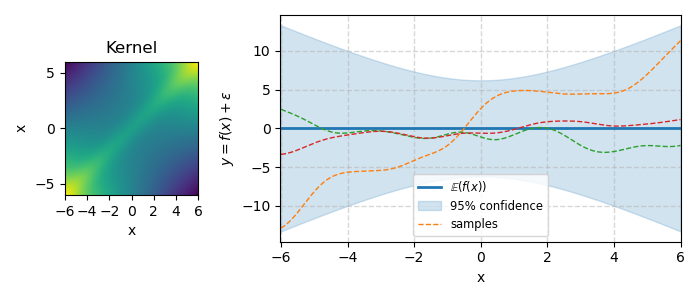

In [60]:
x = np.linspace(-6, 6, 300)
muf = np.zeros(x.shape)
feat_func = lib.FeatureFuncs.linear
cov = lib.KernelFuncs.parametric_function(x, x, feat_func, np.eye(2))
cov += lib.KernelFuncs.squared_exponential(x, x, sigma=3, leng=1)
dist = scystat.multivariate_normal(muf, cov, allow_singular=True)
anim, fig = lib.Animate.gp_distribution(x, dist)

In [61]:
anim.repeat = False
mplt.close(fig)

## Hyper-Parameters of Kernels

Not only the type of the covariance function, but also the value of its hyper-parameters changes the look of the sample functions of the prior, as can be seen in the example below.

<IPython.core.display.Javascript object>


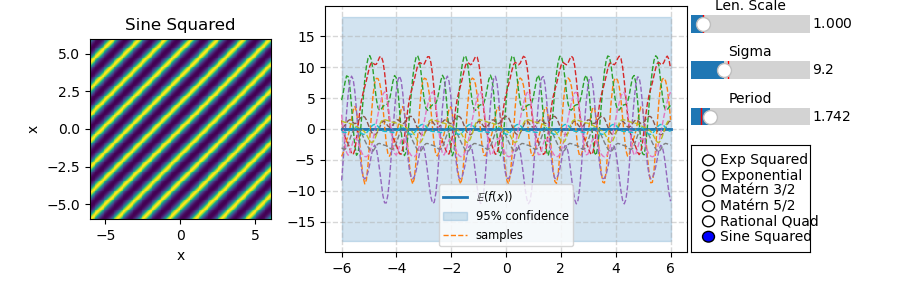

In [79]:
x = np.linspace(-6, 6, 200)
muf = np.zeros(x.shape)
x_, y_ = np.meshgrid(x, x)

fig = mplt.figure(figsize=(9, 3))
gd = mplt.GridSpec(
    1, 2, right=0.9, bottom=0.16, top=0.98, left=0.1, hspace=0.02,
    wspace=0.01, width_ratios=[5, 1])
gds1 = gd[0, 0].subgridspec(1, 2, width_ratios=[1, 2], wspace=0.2)
gds = gd[0, 1].subgridspec(4, 1, height_ratios=[1, 1, 1, 3])
ax = fig.add_subplot(gds1[0, 0])
ay = fig.add_subplot(gds1[0, 1])

aker = fig.add_subplot(gds[3, 0])
alen = fig.add_subplot(gds[0, 0])
asig = fig.add_subplot(gds[1, 0])
aoth = fig.add_subplot(gds[2, 0])

kerns = [
    'Exp Squared', 'Exponential', 'Matérn 3/2', 'Matérn 5/2',
    'Rational Quad', 'Sine Squared']

bker = mplwid.RadioButtons(aker, kerns, active=0)
slen = mplwid.Slider(alen, 'Len. Scale', 0.001, 10, valinit=1)
ssig = mplwid.Slider(asig, 'Sigma', 1, 30, valinit=10)
soth = mplwid.Slider(aoth, 'Other', 0.1, 10, valinit=1)

slen.label.set_position((0.5, 1))
slen.label.set_horizontalalignment('center')
ssig.label.set_position((0.5, 1))
ssig.label.set_horizontalalignment('center')
soth.label.set_position((0.5, 1))
soth.label.set_horizontalalignment('center')

ax.set_ylabel('x')
ax.set_xlabel('x')
ax.set_aspect('equal')
ay.set_xlabel('x')
ay.set_ylabel(r'$y = f(x) + \varepsilon$')

def plot_gp(kernel='Exp Squared', leng=1, sigma=1, other=1):
    kernel = bker.value_selected
    leng = slen.val
    sigma = ssig.val
    other = soth.val
    if kernel == 'Exp Squared':
        kern_func = lib.KernelFuncs.squared_exponential
        aoth.set_visible(False)
    elif kernel == 'Exponential':
        kern_func = lib.KernelFuncs.exponential
        aoth.set_visible(False)
    elif kernel == 'Matérn 3/2':
        kern_func = lib.KernelFuncs.matern3over2
        aoth.set_visible(False)
    elif kernel == 'Matérn 5/2':
        kern_func = lib.KernelFuncs.matern5over2
        aoth.set_visible(False)
    elif kernel == 'Rational Quad':
        aoth.set_visible(True)
        soth.label.set_text('Alpha')
        kern_func = _partial(lib.KernelFuncs.rational_quadratic, alpha=other)
    elif kernel == 'Sine Squared':
        aoth.set_visible(True)
        soth.label.set_text('Period')
        kern_func = _partial(lib.KernelFuncs.sine_squared, period=other)
        
    cov = kern_func(x, x, leng=leng, sigma=sigma)
    dist = scystat.multivariate_normal(muf, cov, allow_singular=True)
    stdf = np.sqrt(np.diag(cov))

    # Create rotating samples from the distribution:
    # First define the levels we want:
    lev_smpl = -2*np.log(np.logspace(-3, 0, 10)*0.995)
    # Create normalized random vectors for rotation:
    N = muf.size
    nvec = lev_smpl.size
    v = np.random.randn(N, nvec)
    v /= np.linalg.norm(v, axis=0)
    v *= lev_smpl[None, :]

    # Create transformation matrix from v
    chol_cov = np.linalg.cholesky(cov + 1e-10*np.eye(cov.shape[0]))
    v = muf[:, None] + chol_cov @ v

    ax.pcolormesh(x_, y_, cov)
    ax.set_title(kernel)

    ay.clear()

    ay.plot(x, muf, label=r'$\mathbb{E}(f(x))$')
    ay.fill_between(
        x, muf+1.96*stdf, muf-1.96*stdf, color='C0', alpha=0.2,
        label='95% confidence')
    lines = [
        ay.plot(
            x, xd, '--', color=f'C{i:d}', lw=1)[0]
        for i, xd in enumerate(v.T, 1)]
    lines[0].set_label('samples')

    ay.legend(
        loc='lower center', bbox_to_anchor=(0.5, 0), fontsize='small')
    fig.canvas.draw_idle()

bker.on_clicked(plot_gp)
slen.on_changed(plot_gp)
ssig.on_changed(plot_gp)
soth.on_changed(plot_gp)
plot_gp()
fig.show()

# Regression with Gaussian Processes

The idea is that the Gaussian Process describes a prior, which can be updated when new data is measured via Bayes Theorem. Let's check how this works below: suppose we perform $m$ noisy measurements of $f(\vect{x})$ at locations

$$\vect{X} = (\vect{x_1}, \cdots, \vect{x_m}),$$

and want to know the posterior of $f(x)$ at another $p$ points

$$\vect{X_*} = (\vect{x_{m+1}}, \cdots, \vect{x_{m+p}}),$$

The prior joint distribution of $\vect{f}(\vect{X})$ and $\vect{f}(\vect{X_*})$ is given by:

$$\begin{pmatrix}\vect{f} \\ \vect{f_*} \end{pmatrix} \sim \mathcal{N}\left(
\begin{pmatrix}\vect{m} \\ \vect{m_*}\end{pmatrix},\,\,
\begin{pmatrix}\vect{K} & \vect{K_*}^T \\ \vect{K_*} & \vect{K_{**}} \end{pmatrix}
\right)$$

where we introduced a short notation 
$$\vect{m}=\vect{m}(\vect{X}), \quad \vect{f}=\vect{m}(\vect{X}),$$ 

$$\vect{m_*}=\vect{m}(\vect{X_*}),\quad \vect{f_*}=\vect{m}(\vect{X_*}),$$ 

$$\vect{K}=\vect{K}(\vect{X}, \vect{X}), \quad \vect{K_*}=\vect{K}(\vect{X_*}, \vect{X})=\vect{K}(\vect{X}, \vect{X_*})^T,\,\, \mathrm{and} \quad \vect{K_{**}}=\vect{K}(\vect{X_*}, \vect{X_*}).$$

If we assume the noisy measurements $\vect{y}$ all have the same uncertainty $\varepsilon_i\sim\mathcal{N}(0, \sigma)$:

$$\vect{y} = \vect{f} + \vect{\varepsilon}, \quad \mathrm{with}\quad
\vect{\varepsilon}=(\varepsilon_1,\cdots, \varepsilon_m),$$

the joint distribution of $\vect{y}$ and $\vect{f_*}$ is given by:

$$\begin{pmatrix}\vect{y} \\ \vect{f_*} \end{pmatrix} \sim \mathcal{N}\left(
\begin{pmatrix}\vect{m} \\ \vect{m_*}\end{pmatrix},\,\,
\begin{pmatrix}\vect{K} + \sigma^2\vect{I} & \vect{K_*}^T \\ \vect{K_*} & \vect{K_{**}} \end{pmatrix}
\right).$$

This way, the posterior of $\vect{f_*}$ can be calculated simply by taking the conditional probability below:

$$P(\vect{f_*}|\vect{X}, \vect{y}, \vect{X^*}) = \mathcal{N}\left(
\vect{m_*} + \vect{K_*}(\vect{K}+\sigma^2\vect{I})^{-1})(\vect{y}- \vect{m}),\,\,
\vect{K_{**}} - \vect{K_*}(\vect{K}+\sigma^2\vect{I})^{-1})\vect{K_*}^T)
\right)$$

<IPython.core.display.Javascript object>


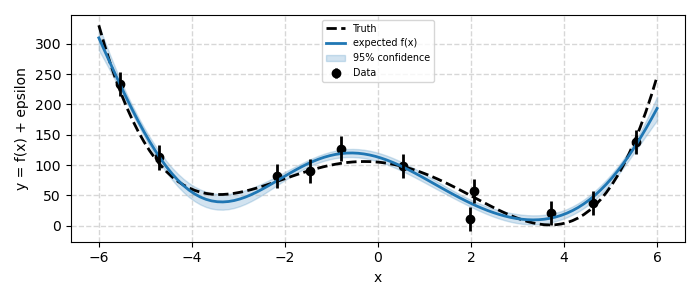

In [84]:
kernel_func = _partial(lib.KernelFuncs.squared_exponential, sigma=300, leng=3)
anim, fig = lib.Animate.gp_regression(
    x, x_data, y_data, kernel_func, sigma_err=sigma_err, truth=truth)

In [85]:
anim.repeat = False
mplt.close(fig)

The posterior of the distribution is given below:

<IPython.core.display.Javascript object>


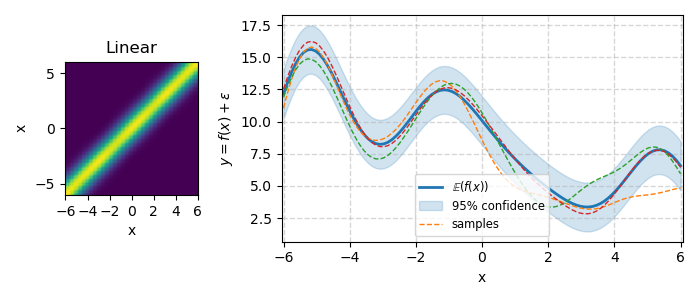

In [86]:
post = lib.Regressions.non_parametric(
    x, x_data, y_data, lib.KernelFuncs.squared_exponential, noise_var=sigma_err)
anim, fig = lib.Animate.gp_distribution(x, post, 'Linear')

In [87]:
anim.repeat = False
mplt.close(fig)